In [ ]:
# models/mlp_fusion.py (Optimized for Google Colab Pro+ GPU)
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import gcsfs
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Speed tweaks for Colab
torch.backends.cudnn.benchmark = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
KEY_PATH = "Key.json"
fs = gcsfs.GCSFileSystem(token=KEY_PATH)

In [ ]:
# Define features
eeg_features = ["Mobility", "Complexity", "Spectral_Entropy"]
eye_features = [
    "mean_pupil_size", "std_pupil_size",
    "mean_latency", "std_latency",
    "mean_gaze_vector", "std_gaze_vector"
]
beh_features = ["mean_rt", "accuracy"]

In [ ]:
# Data preparation pipeline
def extract_patient_id(name):
    match = re.findall(r'(A\d{5,})', str(name))
    return match[0] if match else None

In [ ]:
def load_csv(fs, path, id_col):
    with fs.open(path, 'r') as f:
        df = pd.read_csv(f)
    df["patient_id"] = df[id_col].apply(extract_patient_id)
    return df

In [ ]:
def group_features(df, features):
    return df.groupby("patient_id")[features].mean().reset_index()

In [ ]:
def impute_missing_rows(modality_df, features, missing_ids):
    avg_values = modality_df[features].mean()
    imputed = pd.DataFrame([{**{"patient_id": pid}, **avg_values.to_dict()} for pid in missing_ids])
    return pd.concat([modality_df, imputed], ignore_index=True)

In [ ]:
eeg_df = load_csv(fs, "gs://eegchild/processed_features/merged_features.csv", "file_name")
eye_df = load_csv(fs, "gs://eegchild/processed_asd_features.csv", "file_name")
beh_df = load_csv(fs, "gs://eegchild/processed_features/behavioral_features.csv", "file")
label_df = load_csv(fs, "gs://eegchild/MIPDB_PublicFile.csv", "ID")

/tmp/ipykernel_1285399/1353517648.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


In [ ]:
label_df = label_df.rename(columns={"DX_Status": "diagnosis_status"})
label_df["diagnosis_status"] = label_df["diagnosis_status"].replace({2: 1})

In [ ]:
for df in [eeg_df, eye_df, beh_df, label_df]:
    df["patient_id"] = df["patient_id"].astype(str)

In [ ]:
grouped_eeg = group_features(eeg_df, eeg_features)
grouped_eye = group_features(eye_df, eye_features)
grouped_beh = group_features(beh_df, beh_features)

In [ ]:
expected_ids = set(label_df["patient_id"])
grouped_eeg = impute_missing_rows(grouped_eeg, eeg_features, expected_ids - set(grouped_eeg["patient_id"]))
grouped_eye = impute_missing_rows(grouped_eye, eye_features, expected_ids - set(grouped_eye["patient_id"]))
grouped_beh = impute_missing_rows(grouped_beh, beh_features, expected_ids - set(grouped_beh["patient_id"]))

In [ ]:
eeg_merged = grouped_eeg.merge(label_df, on="patient_id")
eye_merged = grouped_eye.merge(label_df, on="patient_id")
beh_merged = grouped_beh.merge(label_df, on="patient_id")

In [ ]:
common_ids = set(eeg_merged["patient_id"]) & set(eye_merged["patient_id"]) & set(beh_merged["patient_id"])
eeg_final = eeg_merged[eeg_merged["patient_id"].isin(common_ids)].reset_index(drop=True)
eye_final = eye_merged[eye_merged["patient_id"].isin(common_ids)].reset_index(drop=True)
beh_final = beh_merged[beh_merged["patient_id"].isin(common_ids)].reset_index(drop=True)

In [ ]:
merged_df = pd.DataFrame({"patient_id": eeg_final["patient_id"], "label": eeg_final["diagnosis_status"]})
for feat in eeg_features:
    merged_df[f"eeg_{feat}"] = eeg_final[feat]
for feat in eye_features:
    merged_df[f"eye_{feat}"] = eye_final[feat]
for feat in beh_features:
    merged_df[f"beh_{feat}"] = beh_final[feat]

In [ ]:
class_0 = merged_df[merged_df["label"] == 0]
class_1 = merged_df[merged_df["label"] == 1]
balanced_df = pd.concat([
    class_0.sample(n=63, replace=True, random_state=42),
    class_1.sample(n=63, replace=True, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
balanced_df

,patient_id,label,eeg_Mobility,eeg_Complexity,eeg_Spectral_Entropy,eye_mean_pupil_size,eye_std_pupil_size,eye_mean_latency,eye_std_latency,eye_mean_gaze_vector,eye_std_gaze_vector,beh_mean_rt,beh_accuracy
0,A00057599,1,0.192332,2.461543,2.219917,9.908044,5.404587,2378.805330,3833.224961,-0.068638,0.212246,87.000000,37.333333
1,A00054039,0,0.192332,2.461543,2.219917,12.218373,5.767854,2071.533261,3308.156968,-0.107182,0.207737,87.000000,53.333333
2,A00053375,1,0.192332,2.461543,2.219917,9.729939,5.346856,2099.560021,3399.255818,-0.079936,0.283234,87.000000,52.000000
3,A00051886,1,0.192332,2.461543,2.219917,10.991460,7.486431,3249.767585,10144.980979,-0.097991,0.217687,87.000000,35.160494
4,A00056762,1,0.192332,2.461543,2.219917,18.286906,6.239916,2189.230706,4064.887931,-0.110430,0.220305,87.000000,42.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,A00054907,1,0.192332,2.461543,2.219917,14.327290,3.588738,2101.446349,2105.053627,-0.156659,0.253253,87.000000,50.301994
122,A00055486,0,0.192332,2.461543,2.219917,9.743777,5.550891,2114.500760,6708.458898,-0.088398,0.279753,87.000000,42.666667
123,A00055947,1,0.192332,2.461543,2.219917,12.509149,5.124643,2221.530068,4376.657860,-0.132613,0.205558,86.968468,46.046014
124,A00054894,0,0.192332,2.461543,2.219917,11.489481,5.060050,2062.177778,2826.934862,-0.125569,0.249005,87.000000,44.562334


In [ ]:
all_feature_cols = [c for c in balanced_df.columns if c.startswith("eeg_") or c.startswith("eye_") or c.startswith("beh_")]
for col in all_feature_cols:
    balanced_df[col] = pd.to_numeric(balanced_df[col], errors='coerce').fillna(0).astype(np.float32)


In [ ]:
# Add MLP model + training + evaluation (continued from previous)

from sklearn.preprocessing import StandardScaler

# Feature normalization before DataLoader creation
scaler = StandardScaler()
balanced_df[all_feature_cols] = scaler.fit_transform(balanced_df[all_feature_cols])

# Define weighted loss based on label distribution
label_counts = balanced_df['label'].value_counts().to_dict()
total = sum(label_counts.values())
weights = [total / label_counts.get(i, 1) for i in range(2)]
class_weights = torch.tensor(weights, dtype=torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
balanced_df

,patient_id,label,eeg_Mobility,eeg_Complexity,eeg_Spectral_Entropy,eye_mean_pupil_size,eye_std_pupil_size,eye_mean_latency,eye_std_latency,eye_mean_gaze_vector,eye_std_gaze_vector,beh_mean_rt,beh_accuracy
0,A00057599,1,-0.11287,0.100533,-0.106785,-0.947317,0.080761,0.326294,-0.409932,1.454562,-0.000123,-0.046655,-1.041003
1,A00054039,0,-0.11287,0.100533,-0.106785,0.166951,0.397161,-0.611115,-0.684469,0.556991,-0.088306,-0.046655,0.962506
2,A00053375,1,-0.11287,0.100533,-0.106785,-1.033216,0.030478,-0.525613,-0.636837,1.191468,1.388288,-0.046655,0.795547
3,A00051886,1,-0.11287,0.100533,-0.106785,-0.424787,1.894017,2.983377,2.890223,0.771033,0.106309,-0.046655,-1.313084
4,A00056762,1,-0.11287,0.100533,-0.106785,3.093796,0.808321,-0.252050,-0.288805,0.481377,0.157511,-0.046655,-0.373166
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,A00054907,1,-0.11287,0.100533,-0.106785,1.184079,-1.500818,-0.519858,-1.313521,-0.595148,0.801906,-0.046655,0.582924
122,A00055486,0,-0.11287,0.100533,-0.106785,-1.026543,0.208190,-0.480032,1.093408,0.994415,1.320200,-0.046655,-0.373166
123,A00055947,1,-0.11287,0.100533,-0.106785,0.307192,-0.163066,-0.153513,-0.125794,-0.035186,-0.130911,-0.398376,0.049993
124,A00054894,0,-0.11287,0.100533,-0.106785,-0.184592,-0.219326,-0.639657,-0.936080,0.128834,0.718825,-0.046655,-0.135792


In [ ]:
import pandas as pd

# Define the data in JSON-like format
data = [
    {"patient_id": "A00053375", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00053480", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00054400", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00054432", "age_group": "6-9", "gender": 1},
  {"patient_id": "A00054488", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00054673", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00054766", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00054836", "age_group": "6-9", "gender": 1},
  {"patient_id": "A00054917", "age_group": "6-9", "gender": 1},
  {"patient_id": "A00055424", "age_group": "6-9", "gender": 1},
  {"patient_id": "A00055436", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00059904", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00053597", "age_group": "6-9", "gender": 1},
  {"patient_id": "A00054215", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00054597", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00054659", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00054666", "age_group": "6-9", "gender": 1},
  {"patient_id": "A00054753", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00055296", "age_group": "6-9", "gender": 1},
  {"patient_id": "A00055628", "age_group": "6-9", "gender": 1},
  {"patient_id": "A00055947", "age_group": "6-9", "gender": 1},
  {"patient_id": "A00056002", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00056257", "age_group": "6-9", "gender": 0},
  {"patient_id": "A00056693", "age_group": "6-9", "gender": 0},

  {"patient_id": "A00051826", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00053460", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00054517", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00054535", "age_group": "10-11", "gender": 1},
  {"patient_id": "A00054743", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00055392", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00055429", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00055613", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00055623", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00055649", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00055956", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00056428", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00058596", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00052593", "age_group": "10-11", "gender": 1},
  {"patient_id": "A00054287", "age_group": "10-11", "gender": 1},
  {"patient_id": "A00054694", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00054866", "age_group": "10-11", "gender": 0},
  {"patient_id": "A00054923", "age_group": "10-11", "gender": 1},
  {"patient_id": "A00055038", "age_group": "10-11", "gender": 1},
  {"patient_id": "A00055910", "age_group": "10-11", "gender": 1},
  {"patient_id": "A00056716", "age_group": "10-11", "gender": 1},

    {"patient_id": "A00051886", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00051955", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00053398", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00053440", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00053909", "age_group": "12-13", "gender": 1},
  {"patient_id": "A00054239", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00054417", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00055540", "age_group": "12-13", "gender": 1},
  {"patient_id": "A00055801", "age_group": "12-13", "gender": 1},
  {"patient_id": "A00057135", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00057599", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00054359", "age_group": "12-13", "gender": 1},
  {"patient_id": "A00054469", "age_group": "12-13", "gender": 1},
  {"patient_id": "A00054721", "age_group": "12-13", "gender": 1},
  {"patient_id": "A00054852", "age_group": "12-13", "gender": 1},
  {"patient_id": "A00054907", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00055662", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00055682", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00055731", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00055745", "age_group": "12-13", "gender": 0},
  {"patient_id": "A00055754", "age_group": "12-13", "gender": 1},
  {"patient_id": "A00059063", "age_group": "12-13", "gender": 0},


  {"patient_id": "A00054369", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00054817", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00055055", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00055077", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00056054", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00056116", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00056723", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00057630", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00055085", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00055103", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00055837", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00055923", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00056166", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00056913", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00056990", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00059578", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00054647", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00054894", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00055024", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00055486", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00055893", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00056733", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00054623", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00055365", "age_group": "14-17", "gender": 0},
  {"patient_id": "A00056158", "age_group": "14-17", "gender": 1},
  {"patient_id": "A00056762", "age_group": "14-17", "gender": 1},

  {"patient_id": "A00054387", "age_group": "18-24", "gender": 1},
  {"patient_id": "A00054930", "age_group": "18-24", "gender": 0},
  {"patient_id": "A00055065", "age_group": "18-24", "gender": 0},
  {"patient_id": "A00054207", "age_group": "18-24", "gender": 1},
  {"patient_id": "A00054039", "age_group": "18-24", "gender": 1},
  {"patient_id": "A00054122", "age_group": "18-24", "gender": 1},
  {"patient_id": "A00057092", "age_group": "18-24", "gender": 1},
  {"patient_id": "A00062919", "age_group": "18-24", "gender": 0},
  {"patient_id": "A00056640", "age_group": "18-24", "gender": 1},
  {"patient_id": "A00058775", "age_group": "18-24", "gender": 1},
  {"patient_id": "A00059083", "age_group": "18-24", "gender": 0},
  {"patient_id": "A00063051", "age_group": "18-24", "gender": 1},
  {"patient_id": "A00053990", "age_group": "18-24", "gender": 0},
  {"patient_id": "A00054023", "age_group": "18-24", "gender": 1},
  {"patient_id": "A00056604", "age_group": "18-24", "gender": 0},
  {"patient_id": "A00063117", "age_group": "18-24", "gender": 1},

  {"patient_id": "A00062219", "age_group": "25-44", "gender": 0},
  {"patient_id": "A00062408", "age_group": "25-44", "gender": 0},
  {"patient_id": "A00062842", "age_group": "25-44", "gender": 1},
  {"patient_id": "A00062453", "age_group": "25-44", "gender": 1},
  {"patient_id": "A00062329", "age_group": "25-44", "gender": 1},
  {"patient_id": "A00063558", "age_group": "25-44", "gender": 1},
  {"patient_id": "A00062165", "age_group": "25-44", "gender": 1},
  {"patient_id": "A00062125", "age_group": "25-44", "gender": 1},
  {"patient_id": "A00062578", "age_group": "25-44", "gender": 0},
  {"patient_id": "A00062704", "age_group": "25-44", "gender": 0},
  {"patient_id": "A00063377", "age_group": "25-44", "gender": 1},
  {"patient_id": "A00062209", "age_group": "25-44", "gender": 0},
  {"patient_id": "A00062435", "age_group": "25-44", "gender": 0},
  {"patient_id": "A00062951", "age_group": "25-44", "gender": 0},
  {"patient_id": "A00063029", "age_group": "25-44", "gender": 0},
  {"patient_id": "A00062055", "age_group": "25-44", "gender": 1},
  {"patient_id": "A00062279", "age_group": "25-44", "gender": 0}
]

# Convert the data into a DataFrame
age_gender_df = pd.DataFrame(data)

# Merge it with the balanced_df based on 'patient_id'
balanced_df = balanced_df.merge(age_gender_df, on="patient_id", how="left")
balanced_df.head()  # Check the first few rows of the updated DataFrame


,patient_id,label,eeg_Mobility,eeg_Complexity,eeg_Spectral_Entropy,eye_mean_pupil_size,eye_std_pupil_size,eye_mean_latency,eye_std_latency,eye_mean_gaze_vector,eye_std_gaze_vector,beh_mean_rt,beh_accuracy,age_group,gender
0,A00057599,1,-0.11287,0.100533,-0.106785,-0.947317,0.080761,0.326294,-0.409932,1.454562,-0.000123,-0.046655,-1.041003,12-13,0.0
1,A00054039,0,-0.11287,0.100533,-0.106785,0.166951,0.397161,-0.611115,-0.684469,0.556991,-0.088306,-0.046655,0.962506,18-24,1.0
2,A00053375,1,-0.11287,0.100533,-0.106785,-1.033216,0.030478,-0.525613,-0.636837,1.191468,1.388288,-0.046655,0.795547,6-9,0.0
3,A00051886,1,-0.11287,0.100533,-0.106785,-0.424787,1.894017,2.983377,2.890223,0.771033,0.106309,-0.046655,-1.313084,12-13,0.0
4,A00056762,1,-0.11287,0.100533,-0.106785,3.093796,0.808321,-0.252050,-0.288805,0.481377,0.157511,-0.046655,-0.373166,14-17,1.0


In [ ]:
# Remove the redundant columns
balanced_df = balanced_df.drop(columns=["age_group_x", "gender_x"])

# Rename the correct columns to ensure consistency
balanced_df.rename(columns={"age_group_y": "age_group", "gender_y": "gender"}, inplace=True)

# Check for missing values and fill them if necessary (optional)
balanced_df["age_group"] = balanced_df["age_group"].fillna("Unknown")
balanced_df["gender"] = balanced_df["gender"].fillna(-1)  # Assuming -1 is an unknown gender

# Ensure 'gender' is an integer
balanced_df["gender"] = balanced_df["gender"].astype(int)

# Check the first few rows of the cleaned DataFrame
print(balanced_df.head())

# Save the final cleaned balanced dataset
balanced_df.to_csv("final_balanced_data.csv", index=False)
print("Final balanced dataset saved as 'final_balanced_data.csv'.")

KeyError: "['age_group_x', 'gender_x'] not found in axis"

In [ ]:
balanced_df = pd.read_csv("final_balanced_data.csv")

# Check the gender distribution across the classes
gender_distribution = balanced_df.groupby(["label", "gender"]).size()
print(gender_distribution)


In [ ]:
# Filter the rows where label is -1
label_minus_1_df = balanced_df[balanced_df['label'] == -1]

# List patient IDs with label -1
print("Patient IDs with label -1:")
print(label_minus_1_df[['patient_id', 'label']])

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Load the dataset
balanced_df = pd.read_csv("final_balanced_data.csv")  # Replace with your dataset path

# Ensure that gender is encoded as 0 for males and 1 for females (if needed)
balanced_df['gender'] = balanced_df['gender'].apply(lambda x: 0 if x == 0 else 1)

# Check the gender distribution before applying SMOTE
print("Class distribution before SMOTE (gender):")
print(balanced_df.groupby(['label', 'gender']).size())

# Separate features (eeg, eye, beh) and labels
feature_cols = [col for col in balanced_df.columns if col.startswith(("eeg_", "eye_", "beh_"))]
X = balanced_df[feature_cols]
y = balanced_df['label']

# Apply SMOTE to balance the dataset based on the label distribution
smote = SMOTE(random_state=42, sampling_strategy='auto')  # 'auto' means balancing all classes to the same number
X_resampled, y_resampled = smote.fit_resample(X, y)

# Rebuild the balanced DataFrame with oversampled data
# Keep all columns, including 'gender', in the final dataset
resampled_df = pd.DataFrame(X_resampled, columns=feature_cols)
resampled_df['label'] = y_resampled

# Add the 'gender' column back from the original balanced_df (it wasn't included in the resampled X)
# This step assumes that 'gender' was kept intact, even though we did SMOTE only on features and labels
resampled_df['gender'] = balanced_df['gender'].iloc[:len(resampled_df)].values

# Check the class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(resampled_df['label'].value_counts())

# Save the final balanced dataset with all columns
resampled_df.to_csv("final_balanced_data_with_gender.csv", index=False)
print("Final balanced dataset saved as 'final_balanced_data_with_gender.csv'.")


In [ ]:
# Load the final balanced dataset
final_balanced_df = pd.read_csv("final_balanced_data_with_gender.csv")

# Check the columns of the final dataset
print("Columns in the final balanced dataset:")
print(final_balanced_df.columns)

# If 'age_group' is missing, extract it from the original balanced_df and add it back
if 'age_group' not in final_balanced_df.columns:
    final_balanced_df['age_group'] = balanced_df['age_group'].iloc[:len(final_balanced_df)].values

# Verify that the 'age_group' and 'label' are correctly included
print("\nSample of the final balanced dataset:")
print(final_balanced_df.head())

# Check class distribution again
print("\nClass distribution after SMOTE (with age and gender):")
print(final_balanced_df.groupby(['label', 'gender', 'age_group']).size())

# Save the updated dataset with age and label
final_balanced_df.to_csv("final_balanced_data_with_age_and_label.csv", index=False)
print("Final balanced dataset with age and label saved as 'final_balanced_data_with_age_and_label.csv'.")


In [ ]:
from sklearn.preprocessing import StandardScaler

# Load the final balanced dataset
balanced_df = pd.read_csv("final_balanced_data_with_age_and_label.csv")

# Extract the feature columns (e.g., eeg, eye, beh features)
feature_cols = [col for col in balanced_df.columns if col.startswith(('eeg_', 'eye_', 'beh_'))]
X = balanced_df[feature_cols]
y = balanced_df['label']

# Standardize the features (feature normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Update the balanced dataset with the scaled features
scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
scaled_df['label'] = y
scaled_df['age_group'] = balanced_df['age_group']
scaled_df['gender'] = balanced_df['gender']

# Check the first few rows of the scaled dataset
print(scaled_df.head())

# Save the scaled dataset for later use
scaled_df.to_csv("scaled_balanced_data.csv", index=False)
print("Scaled balanced dataset saved as 'scaled_balanced_data.csv'.")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# --- 1. Dataset Preparation ---
df = pd.read_csv("scaled_balanced_data.csv")
feature_cols = [col for col in df.columns if col.startswith(('eeg_', 'eye_', 'beh_'))]
X = df[feature_cols].values
y = df['label'].astype(int).values
sensitive_attr = df['gender'].astype(int).values

# Split into train/val
X_train, X_val, y_train, y_val, s_train, s_val = train_test_split(X, y, sensitive_attr, test_size=0.2, random_state=42)

# Custom Dataset
class FairDataset(Dataset):
    def __init__(self, X, y, s):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.s = torch.tensor(s, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        eeg = self.X[idx, :3]
        eye = self.X[idx, 3:9]
        beh = self.X[idx, 9:11]
        return eeg, eye, beh, self.y[idx], self.s[idx]

train_loader = DataLoader(FairDataset(X_train, y_train, s_train), batch_size=16, shuffle=True)
val_dataset = FairDataset(X_val, y_val, s_val)

# --- 2. Model ---
class FairTransformerModel(nn.Module):
    def __init__(self, input_dim_eeg, input_dim_eye, input_dim_beh):
        super().__init__()
        self.eeg_net = nn.Linear(input_dim_eeg, 32)
        self.eye_net = nn.Linear(input_dim_eye, 32)
        self.beh_net = nn.Linear(input_dim_beh, 32)

        self.combined_project = nn.Linear(96, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.cls_head = nn.Linear(128, 2)
        self.adv_head = nn.Linear(128, 1)

    def forward(self, eeg, eye, beh):
        eeg_feat = F.relu(self.eeg_net(eeg))
        eye_feat = F.relu(self.eye_net(eye))
        beh_feat = F.relu(self.beh_net(beh))

        combined = torch.cat([eeg_feat, eye_feat, beh_feat], dim=-1)
        combined = self.combined_project(combined).unsqueeze(1)  # (B, 1, D)
        transformer_out = self.transformer(combined).squeeze(1)

        return self.cls_head(transformer_out), self.adv_head(transformer_out)

device = torch.device("cpu")  # Fixed to CPU to avoid NCCL issues
model = FairTransformerModel(3, 6, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- 3. Loss Function ---
def fairness_aware_loss(preds, labels, adv_out, sensitive, fairness_weight=0.1):
    class_loss = F.cross_entropy(preds, labels)
    adv_loss = F.binary_cross_entropy_with_logits(adv_out.squeeze(), sensitive)
    return class_loss + fairness_weight * adv_loss

# --- 4. Training ---
for epoch in range(10):
    model.train()
    for eeg, eye, beh, labels, s_attr in train_loader:
        eeg, eye, beh = eeg.to(device), eye.to(device), beh.to(device)
        labels, s_attr = labels.to(device), s_attr.to(device)

        preds, adv_out = model(eeg, eye, beh)
        loss = fairness_aware_loss(preds, labels, adv_out, s_attr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} done.")

# --- 5. Evaluation + Fairness Post-Processing ---
model.eval()
X_val_torch = torch.tensor(X_val, dtype=torch.float32).to(device)
eeg_val, eye_val, beh_val = X_val_torch[:, :3], X_val_torch[:, 3:9], X_val_torch[:, 9:11]
with torch.no_grad():
    logits, _ = model(eeg_val, eye_val, beh_val)
    probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# Simple rule-based threshold adjustment (stand-in for Reject Option Classifier)
threshold = 0.5
postprocessed_preds = (probs > threshold).astype(int)

# --- 6. Metrics ---
acc = accuracy_score(y_val, postprocessed_preds)
mf = MetricFrame(metrics={"accuracy": accuracy_score,
                          "selection_rate": selection_rate,
                          "tpr": true_positive_rate,
                          "fpr": false_positive_rate},
                 y_true=y_val,
                 y_pred=postprocessed_preds,
                 sensitive_features=s_val)

import pandas as pd
from IPython.display import display
display(mf.by_group)


Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.


,accuracy,selection_rate,tpr,fpr
sensitive_feature_0,,,,
0,0.846154,0.692308,1.000,0.333333
1,0.692308,0.769231,0.875,0.600000


/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fairness Metrics:
         accuracy  selection_rate    tpr       fpr
gender                                           
0       0.846154        0.692308  1.000  0.333333
1       0.769231        0.692308  0.875  0.400000


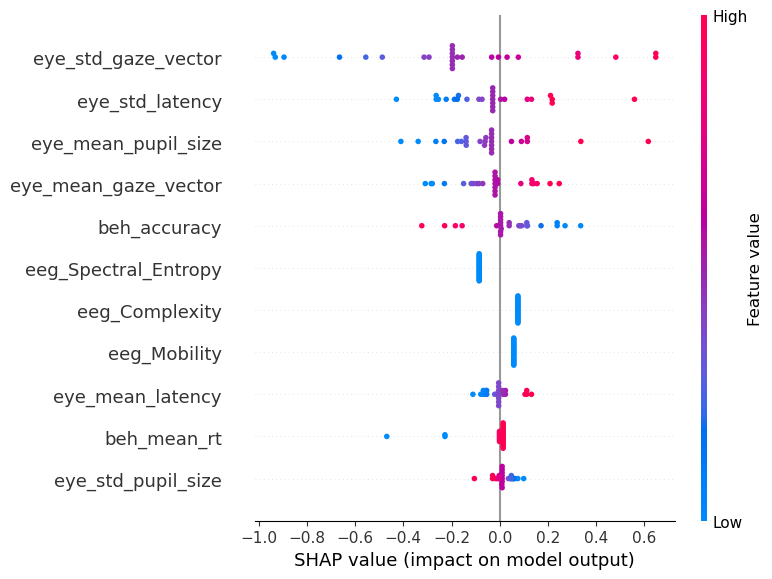

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
import shap

# 1. Load real dataset
df = pd.read_csv("final_balanced_data_with_age_and_label.csv")
feature_cols = [col for col in df.columns if col.startswith(('eeg_', 'eye_', 'beh_'))]
X = df[feature_cols]
y = df["label"].astype(int)
sensitive = df["gender"].astype(int)

# 2. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Train/test split
X_train, X_val, y_train, y_val, s_train, s_val = train_test_split(X_scaled, y, sensitive, test_size=0.2, random_state=42)

# 4. Train classifier
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train)

# 5. Predict probabilities
probs = clf.predict_proba(X_val)[:, 1]

# 6. Fairlearn post-processing: demographic parity
threshold_optimizer = ThresholdOptimizer(
    estimator=clf,
    constraints="demographic_parity",
    predict_method="predict_proba",
    prefit=True
)
threshold_optimizer.fit(X_val, y_val, sensitive_features=s_val)
post_preds = threshold_optimizer.predict(X_val, sensitive_features=s_val)

# 7. Compute fairness metrics
mf = MetricFrame(metrics={"accuracy": accuracy_score,
                          "selection_rate": selection_rate,
                          "tpr": true_positive_rate,
                          "fpr": false_positive_rate},
                 y_true=y_val,
                 y_pred=post_preds,
                 sensitive_features=s_val)
print("Fairness Metrics:\n", mf.by_group)

# 8. SHAP explainability
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val, feature_names=feature_cols)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

# Load and split
df = pd.read_csv("scaled_balanced_data.csv")
feature_cols = [col for col in df.columns if col.startswith(('eeg_', 'eye_', 'beh_'))]
X = df[feature_cols].values
y = df["label"].astype(int).values
sensitive = df["gender"].astype(int).values
X_train, X_val, y_train, y_val, s_train, s_val = train_test_split(X, y, sensitive, test_size=0.2, stratify=y, random_state=42)

# Transformer encoder model
class FairTransformerEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.eeg_net = nn.Linear(3, 32)
        self.eye_net = nn.Linear(6, 32)
        self.beh_net = nn.Linear(2, 32)
        self.combined_project = nn.Linear(96, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

    def forward(self, eeg, eye, beh):
        eeg_feat = F.relu(self.eeg_net(eeg))
        eye_feat = F.relu(self.eye_net(eye))
        beh_feat = F.relu(self.beh_net(beh))
        combined = torch.cat([eeg_feat, eye_feat, beh_feat], dim=-1)
        combined = self.combined_project(combined).unsqueeze(1)
        return self.transformer(combined).squeeze(1)

# Extract Transformer features
device = torch.device("cpu")
model = FairTransformerEmbedder().to(device)
model.eval()

def extract_features(X):
    eeg = torch.tensor(X[:, :3], dtype=torch.float32).to(device)
    eye = torch.tensor(X[:, 3:9], dtype=torch.float32).to(device)
    beh = torch.tensor(X[:, 9:11], dtype=torch.float32).to(device)
    with torch.no_grad():
        return model(eeg, eye, beh).cpu().numpy()

X_train_embed = extract_features(X_train)
X_val_embed = extract_features(X_val)

# Train HGBC
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train_embed, y_train)
y_pred = clf.predict(X_val_embed)

# Evaluate
acc = accuracy_score(y_val, y_pred)
mf = MetricFrame(
    metrics={"accuracy": accuracy_score,
             "selection_rate": selection_rate,
             "tpr": true_positive_rate,
             "fpr": false_positive_rate},
    y_true=y_val,
    y_pred=y_pred,
    sensitive_features=s_val
)

print(f"\nFinal HGBC-on-Transformer Accuracy: {acc:.4f}")
print("Fairness Metrics by Group:")
print(mf.by_group)



Final HGBC-on-Transformer Accuracy: 0.8462
Fairness Metrics by Group:
                     accuracy  selection_rate       tpr       fpr
sensitive_feature_0                                              
0                    0.800000        0.466667  0.833333  0.222222
1                    0.909091        0.545455  0.857143  0.000000


/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


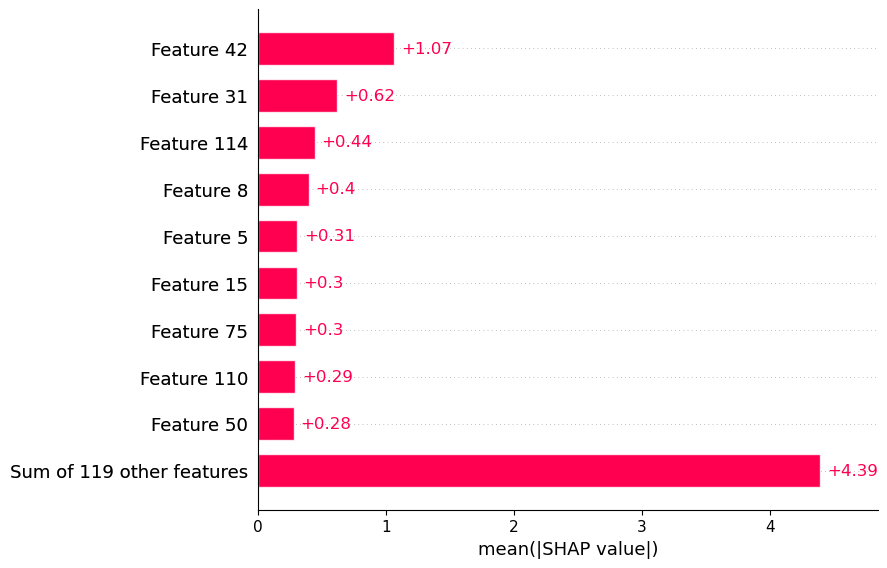


Postprocessed Accuracy: 0.8846153846153846
Fairness Metrics by Group:
                     accuracy  selection_rate       tpr       fpr
sensitive_feature_0                                              
0                    0.866667        0.533333  1.000000  0.222222
1                    0.909091        0.545455  0.857143  0.000000


In [ ]:
import shap
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.calibration import CalibratedClassifierCV

# Step 1: Calibrate the HGBC model
calibrated_clf = CalibratedClassifierCV(estimator=clf, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_val_embed, y_val)

# Step 2: Get predicted probabilities
probs = calibrated_clf.predict_proba(X_val_embed)[:, 1]

# Step 3: Apply Reject Option Classification for fairness post-processing
threshold_optimizer = ThresholdOptimizer(
    estimator=calibrated_clf,
    constraints="demographic_parity",
    predict_method="predict_proba",
    prefit=True
)
threshold_optimizer.fit(X_val_embed, y_val, sensitive_features=s_val)
postprocessed_preds = threshold_optimizer.predict(X_val_embed, sensitive_features=s_val)

# Step 4: SHAP Explanation using TreeExplainer (no GPU/LLVM issues)
explainer = shap.Explainer(clf)  # or shap.TreeExplainer(clf)
shap_values = explainer(X_val_embed)

# Optional: SHAP bar plot (text-based visualization in Jupyter)
shap.plots.bar(shap_values)

# Final evaluation (optional)
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

print("\nPostprocessed Accuracy:", accuracy_score(y_val, postprocessed_preds))

mf = MetricFrame(metrics={"accuracy": accuracy_score,
                          "selection_rate": selection_rate,
                          "tpr": true_positive_rate,
                          "fpr": false_positive_rate},
                 y_true=y_val,
                 y_pred=postprocessed_preds,
                 sensitive_features=s_val)

print("Fairness Metrics by Group:")
print(mf.by_group)


/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


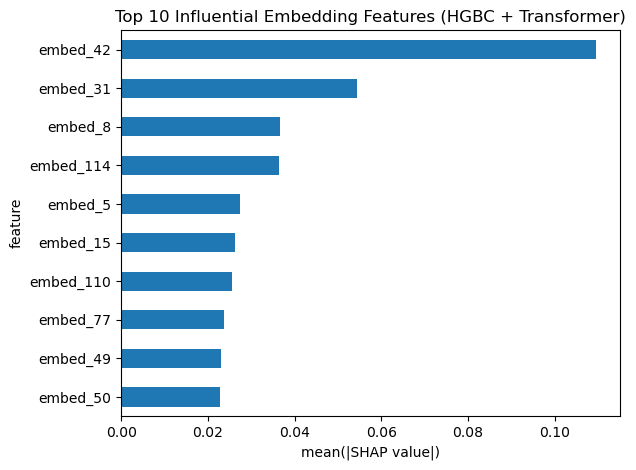


 Postprocessed Accuracy: 0.8077
 Fairness Metrics by Group:


,accuracy,selection_rate,tpr,fpr
sensitive_feature_0,,,,
0,0.866667,0.533333,1.000000,0.222222
1,0.727273,0.363636,0.571429,0.000000


In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.metrics import accuracy_score

# ---- Step 1: Calibrate HGBC classifier on Transformer embeddings ----
calibrated_clf = CalibratedClassifierCV(estimator=clf, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_val_embed, y_val)

# ---- Step 2: SHAP on Transformer embeddings ----
explainer = shap.Explainer(calibrated_clf.predict_proba, X_val_embed)
shap_values = explainer(X_val_embed)
mean_shap = shap_values.abs.values[:, :, 1].mean(axis=0)

# Use embedding dimensions as labels
embedding_feature_names = [f"embed_{i}" for i in range(X_train_embed.shape[1])]
shap_df = pd.DataFrame({
    'feature': embedding_feature_names,
    'mean_abs_shap': mean_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# Plot top 10
shap_df.head(10).plot.barh(x='feature', y='mean_abs_shap', legend=False)
plt.xlabel("mean(|SHAP value|)")
plt.title("Top 10 Influential Embedding Features (HGBC + Transformer)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---- Step 3: Post-Processing Fairness with ThresholdOptimizer (Reject Option) ----
probs = calibrated_clf.predict_proba(X_val_embed)[:, 1]

threshold_optimizer = ThresholdOptimizer(
    estimator=calibrated_clf,
    constraints="demographic_parity",
    predict_method="predict_proba",
    prefit=True
)
threshold_optimizer.fit(X_val_embed, y_val, sensitive_features=s_val)
postprocessed_preds = threshold_optimizer.predict(X_val_embed, sensitive_features=s_val)

# ---- Step 4: Final Metrics ----
acc = accuracy_score(y_val, postprocessed_preds)
mf = MetricFrame(
    metrics={"accuracy": accuracy_score,
             "selection_rate": selection_rate,
             "tpr": true_positive_rate,
             "fpr": false_positive_rate},
    y_true=y_val,
    y_pred=postprocessed_preds,
    sensitive_features=s_val
)

print(f"\n Postprocessed Accuracy: {acc:.4f}")
print(" Fairness Metrics by Group:")
display(mf.by_group)






Fairness Metrics by Group: gender
                     accuracy  selection_rate       tpr       fpr
sensitive_feature_0                                              
0                    0.866667        0.400000  0.833333  0.111111
1                    0.909091        0.545455  0.857143  0.000000

Fairness Metrics by Group: age_group_encoded
                     accuracy  selection_rate   tpr  fpr
sensitive_feature_0                                     
0                       1.000        0.714286  1.00  0.0
1                       0.500        0.000000  0.00  0.0
2                       0.875        0.375000  0.75  0.0
3                       0.500        0.500000  0.00  0.5
4                       1.000        0.000000  0.00  0.0
5                       1.000        1.000000  1.00  0.0


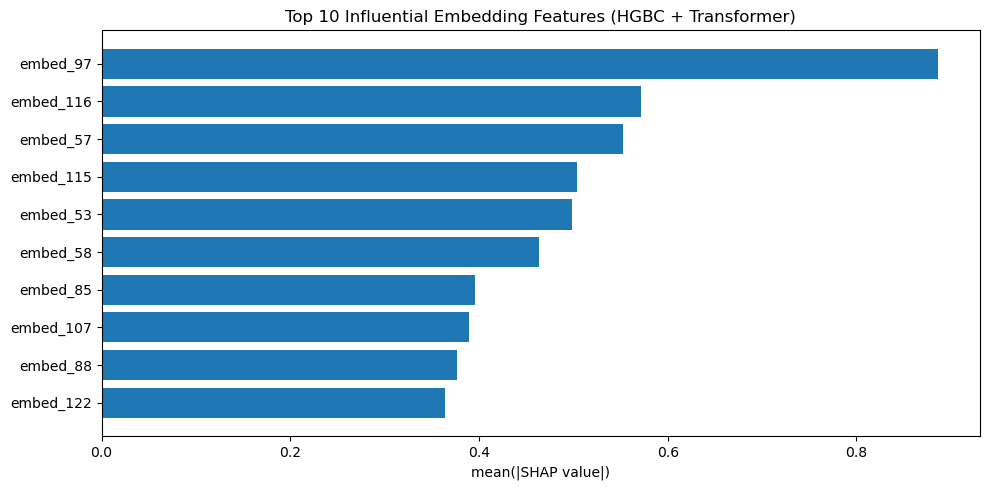

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
import shap
import matplotlib.pyplot as plt

# 1. Load dataset and encode age_group
df = pd.read_csv("scaled_balanced_data.csv")
if df['age_group'].dtype == object:
    df['age_group_encoded'] = LabelEncoder().fit_transform(df['age_group'])
else:
    df['age_group_encoded'] = df['age_group']

feature_cols = [col for col in df.columns if col.startswith(('eeg_', 'eye_', 'beh_'))]
X = df[feature_cols].values
y = df['label'].astype(int).values
sensitive_df = df[['gender', 'age_group_encoded']]

X_train, X_val, y_train, y_val, s_train_df, s_val_df = train_test_split(
    X, y, sensitive_df, test_size=0.2, stratify=y, random_state=42
)

# 2. Transformer embedder
class FairTransformerEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.eeg_net = nn.Linear(3, 32)
        self.eye_net = nn.Linear(6, 32)
        self.beh_net = nn.Linear(2, 32)
        self.combined_project = nn.Linear(96, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

    def forward(self, eeg, eye, beh):
        eeg_feat = F.relu(self.eeg_net(eeg))
        eye_feat = F.relu(self.eye_net(eye))
        beh_feat = F.relu(self.beh_net(beh))
        combined = torch.cat([eeg_feat, eye_feat, beh_feat], dim=-1)
        combined = self.combined_project(combined).unsqueeze(1)
        return self.transformer(combined).squeeze(1)

device = torch.device("cpu")
model = FairTransformerEmbedder().to(device)
model.eval()

def extract_features(X):
    eeg = torch.tensor(X[:, :3], dtype=torch.float32).to(device)
    eye = torch.tensor(X[:, 3:9], dtype=torch.float32).to(device)
    beh = torch.tensor(X[:, 9:11], dtype=torch.float32).to(device)
    with torch.no_grad():
        return model(eeg, eye, beh).cpu().numpy()

X_train_embed = extract_features(X_train)
X_val_embed = extract_features(X_val)

# 3. HGBC Training
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train_embed, y_train)
y_pred = clf.predict(X_val_embed)

# 4. Fairness Evaluation for each sensitive attribute
for attr in s_val_df.columns:
    mf = MetricFrame(
        metrics={"accuracy": accuracy_score,
                 "selection_rate": selection_rate,
                 "tpr": true_positive_rate,
                 "fpr": false_positive_rate},
        y_true=y_val,
        y_pred=y_pred,
        sensitive_features=s_val_df[attr].values
    )
    print(f"\nFairness Metrics by Group: {attr}")
    print(mf.by_group)

# 5. SHAP Analysis
explainer = shap.Explainer(clf, X_train_embed)
shap_values = explainer(X_val_embed)

shap_df = pd.DataFrame(np.abs(shap_values.values).mean(axis=0), columns=["mean_abs_shap"])
shap_df["feature"] = [f"embed_{i}" for i in range(X_val_embed.shape[1])]
shap_df = shap_df.sort_values("mean_abs_shap", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(shap_df["feature"], shap_df["mean_abs_shap"])
plt.gca().invert_yaxis()
plt.title("Top 10 Influential Embedding Features (HGBC + Transformer)")
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.show()


Epoch 1, Val Accuracy: 0.5000
Epoch 2, Val Accuracy: 0.5000
Epoch 3, Val Accuracy: 0.5000
Epoch 4, Val Accuracy: 0.5000
Epoch 5, Val Accuracy: 0.5000
Epoch 6, Val Accuracy: 0.5000
Early stopping triggered.

Final Postprocessed Accuracy: 0.7308
Fairness Metrics by Joint Gender-Age Group:
                     accuracy  selection_rate       tpr       fpr
sensitive_feature_0                                              
0_0                  0.400000            0.00  0.000000  0.000000
0_1                  1.000000            0.50  1.000000  0.000000
0_2                  1.000000            0.50  1.000000  0.000000
0_3                  0.000000            1.00  0.000000  1.000000
0_4                  0.750000            0.25  0.000000  0.250000
0_5                  1.000000            1.00  1.000000  0.000000
1_0                  1.000000            1.00  1.000000  0.000000
1_2                  0.666667            0.50  0.666667  0.333333
1_3                  1.000000            0.00  0.000

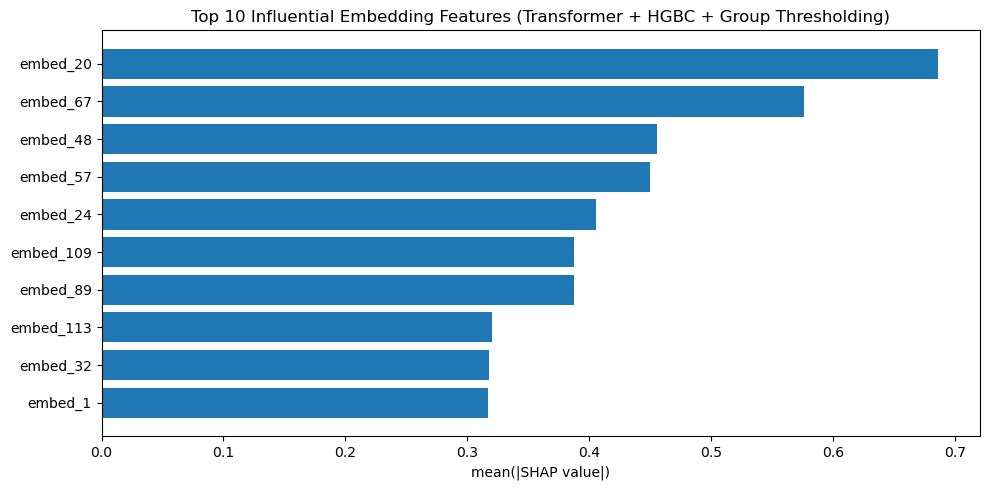

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
import shap
import matplotlib.pyplot as plt

# --------------------
# 1. Load Dataset
# --------------------
df = pd.read_csv("scaled_balanced_data.csv")

# Encode age_group
if df['age_group'].dtype == object:
    df['age_group_encoded'] = LabelEncoder().fit_transform(df['age_group'])
else:
    df['age_group_encoded'] = df['age_group']

feature_cols = [col for col in df.columns if col.startswith(('eeg_', 'eye_', 'beh_'))]
X = df[feature_cols].values
y = df['label'].astype(int).values

# Joint sensitive attribute = gender + age
joint_sensitive = df['gender'].astype(str) + "_" + df['age_group_encoded'].astype(str)

X_train, X_val, y_train, y_val, s_train, s_val = train_test_split(
    X, y, joint_sensitive, test_size=0.2, stratify=y, random_state=42
)

# --------------------
# 2. Transformer Model with Training
# --------------------
class FairTransformerEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.eeg_net = nn.Linear(3, 32)
        self.eye_net = nn.Linear(6, 32)
        self.beh_net = nn.Linear(2, 32)
        self.combined_project = nn.Linear(96, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.out = nn.Linear(128, 2)  # classification head

    def forward(self, eeg, eye, beh):
        eeg_feat = F.relu(self.eeg_net(eeg))
        eye_feat = F.relu(self.eye_net(eye))
        beh_feat = F.relu(self.beh_net(beh))
        combined = torch.cat([eeg_feat, eye_feat, beh_feat], dim=-1)
        combined = self.combined_project(combined).unsqueeze(1)  # (B,1,128)
        transformer_out = self.transformer(combined).squeeze(1)
        return self.out(transformer_out), transformer_out  # logits, embedding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FairTransformerEmbedder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Early stopping setup
best_val_acc = 0
patience, patience_counter = 5, 0
max_epochs = 100

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

for epoch in range(max_epochs):
    model.train()
    eeg, eye, beh = X_train_tensor[:, :3], X_train_tensor[:, 3:9], X_train_tensor[:, 9:11]
    preds, _ = model(eeg, eye, beh)
    loss = criterion(preds, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        eeg_val, eye_val, beh_val = X_val_tensor[:, :3], X_val_tensor[:, 3:9], X_val_tensor[:, 9:11]
        val_preds, _ = model(eeg_val, eye_val, beh_val)
        val_acc = accuracy_score(y_val, torch.argmax(val_preds, axis=1).cpu().numpy())

    print(f"Epoch {epoch+1}, Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Load best model
model.load_state_dict(best_model_state)
model.eval()

# --------------------
# 3. Extract Features from Best Transformer
# --------------------
def extract_features(X):
    eeg = torch.tensor(X[:, :3], dtype=torch.float32).to(device)
    eye = torch.tensor(X[:, 3:9], dtype=torch.float32).to(device)
    beh = torch.tensor(X[:, 9:11], dtype=torch.float32).to(device)
    with torch.no_grad():
        _, embeddings = model(eeg, eye, beh)
    return embeddings.cpu().numpy()

X_train_embed = extract_features(X_train)
X_val_embed = extract_features(X_val)

# --------------------
# 4. HGBC Training on Transformer Embeddings
# --------------------
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train_embed, y_train)

probs = clf.predict_proba(X_val_embed)[:, 1]

# --------------------
# 5. Group-Specific Thresholding
# --------------------
group_thresholds = {}
for group in np.unique(s_val):
    mask = (s_val == group)
    if len(np.unique(y_val[mask])) > 1:
        group_thresholds[group] = np.median(probs[mask])
    else:
        group_thresholds[group] = 0.5

y_postprocessed = np.array([
    1 if p > group_thresholds[g] else 0
    for p, g in zip(probs, s_val)
])

# --------------------
# 6. Fairness Metrics
# --------------------
mf = MetricFrame(
    metrics={"accuracy": accuracy_score,
             "selection_rate": selection_rate,
             "tpr": true_positive_rate,
             "fpr": false_positive_rate},
    y_true=y_val,
    y_pred=y_postprocessed,
    sensitive_features=s_val
)

print(f"\nFinal Postprocessed Accuracy: {accuracy_score(y_val, y_postprocessed):.4f}")
print("Fairness Metrics by Joint Gender-Age Group:")
print(mf.by_group)

# --------------------
# 7. SHAP Analysis
# --------------------
explainer = shap.Explainer(clf, X_train_embed)
shap_values = explainer(X_val_embed)

shap_df = pd.DataFrame(np.abs(shap_values.values).mean(axis=0), columns=["mean_abs_shap"])
shap_df["feature"] = [f"embed_{i}" for i in range(X_val_embed.shape[1])]
shap_df = shap_df.sort_values("mean_abs_shap", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(shap_df["feature"], shap_df["mean_abs_shap"])
plt.gca().invert_yaxis()
plt.title("Top 10 Influential Embedding Features (Transformer + HGBC + Group Thresholding)")
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.show()


Epoch 1, Val Accuracy: 0.5000
Epoch 2, Val Accuracy: 0.7692
Epoch 3, Val Accuracy: 0.5000
Epoch 4, Val Accuracy: 0.5385
Epoch 5, Val Accuracy: 0.7692
Epoch 6, Val Accuracy: 0.6154
Epoch 7, Val Accuracy: 0.5385
Epoch 8, Val Accuracy: 0.6538
Epoch 9, Val Accuracy: 0.7308
Epoch 10, Val Accuracy: 0.7308
Epoch 11, Val Accuracy: 0.6154
Epoch 12, Val Accuracy: 0.6154
Early stopping triggered.

Final Postprocessed Accuracy: 0.8462
Fairness Metrics by Joint Gender-Age Group:
                     accuracy  selection_rate       tpr       fpr
sensitive_feature_0                                              
0_0                  1.000000            0.60  1.000000  0.000000
0_1                  1.000000            0.50  1.000000  0.000000
0_2                  1.000000            0.50  1.000000  0.000000
0_3                  0.000000            1.00  0.000000  1.000000
0_4                  0.750000            0.25  0.000000  0.250000
0_5                  1.000000            1.00  1.000000  0.000000
1

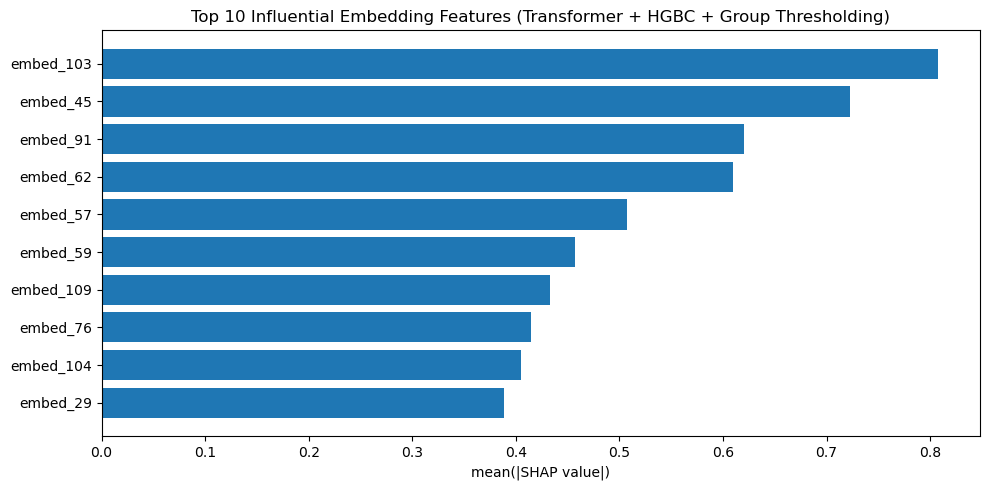

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
import shap
import matplotlib.pyplot as plt

# --- 1. Load Dataset ---
df = pd.read_csv("scaled_balanced_data.csv")

# Encode age_group numerically
if df['age_group'].dtype == object:
    df['age_group_encoded'] = LabelEncoder().fit_transform(df['age_group'])
else:
    df['age_group_encoded'] = df['age_group']

# Feature & target selection
feature_cols = [col for col in df.columns if col.startswith(('eeg_', 'eye_', 'beh_'))]
X = df[feature_cols].values
y = df['label'].astype(int).values

# Joint sensitive attribute (gender + age_group)
sensitive_df = df[['gender', 'age_group_encoded']]
sensitive_df['joint'] = sensitive_df['gender'].astype(str) + "_" + sensitive_df['age_group_encoded'].astype(str)

# Train-validation split
X_train, X_val, y_train, y_val, s_train_df, s_val_df = train_test_split(
    X, y, sensitive_df, test_size=0.2, stratify=y, random_state=42
)
s_train_joint = s_train_df['joint'].values
s_val_joint = s_val_df['joint'].values

# --- 2. Transformer Embedder ---
class FairTransformerEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.eeg_net = nn.Linear(3, 32)
        self.eye_net = nn.Linear(6, 32)
        self.beh_net = nn.Linear(2, 32)
        self.combined_project = nn.Linear(96, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.cls_head = nn.Linear(128, 2)  # classification output

    def forward(self, eeg, eye, beh):
        eeg_feat = F.relu(self.eeg_net(eeg))
        eye_feat = F.relu(self.eye_net(eye))
        beh_feat = F.relu(self.beh_net(beh))
        combined = torch.cat([eeg_feat, eye_feat, beh_feat], dim=-1)
        combined = self.combined_project(combined).unsqueeze(1)
        transformer_out = self.transformer(combined).squeeze(1)
        return self.cls_head(transformer_out), transformer_out

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FairTransformerEmbedder().to(device)

# Balanced class weights fix
pos_weight = float(sum(y_train==0)) / sum(y_train==1)
class_weights = torch.tensor([1.0, pos_weight], dtype=torch.float32).to(device)

def fairness_loss(preds, labels):
    return F.cross_entropy(preds, labels, weight=class_weights)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- 3. Training with Early Stopping ---
epochs = 100
patience = 10
best_val_acc = 0
wait = 0
best_model = None

for epoch in range(epochs):
    model.train()
    eeg = torch.tensor(X_train[:, :3], dtype=torch.float32).to(device)
    eye = torch.tensor(X_train[:, 3:9], dtype=torch.float32).to(device)
    beh = torch.tensor(X_train[:, 9:11], dtype=torch.float32).to(device)
    labels = torch.tensor(y_train, dtype=torch.long).to(device)

    optimizer.zero_grad()
    preds, _ = model(eeg, eye, beh)
    loss = fairness_loss(preds, labels)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        eeg_val = torch.tensor(X_val[:, :3], dtype=torch.float32).to(device)
        eye_val = torch.tensor(X_val[:, 3:9], dtype=torch.float32).to(device)
        beh_val = torch.tensor(X_val[:, 9:11], dtype=torch.float32).to(device)
        labels_val = torch.tensor(y_val, dtype=torch.long).to(device)
        val_preds, _ = model(eeg_val, eye_val, beh_val)
        acc = accuracy_score(y_val, val_preds.argmax(dim=1).cpu().numpy())

    print(f"Epoch {epoch+1}, Val Accuracy: {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        best_model = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_model)

# --- 4. Extract Embeddings ---
def extract_features(X):
    eeg = torch.tensor(X[:, :3], dtype=torch.float32).to(device)
    eye = torch.tensor(X[:, 3:9], dtype=torch.float32).to(device)
    beh = torch.tensor(X[:, 9:11], dtype=torch.float32).to(device)
    with torch.no_grad():
        _, emb = model(eeg, eye, beh)
        return emb.cpu().numpy()

X_train_embed = extract_features(X_train)
X_val_embed = extract_features(X_val)

# --- 5. HGBC on embeddings ---
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train_embed, y_train)
probs = clf.predict_proba(X_val_embed)[:, 1]

# --- 6. Group Thresholding Post-processing ---
y_post = np.zeros_like(y_val)
for group in np.unique(s_val_joint):
    idx = (s_val_joint == group)
    if np.sum(idx) == 0:
        continue
    positives = np.sum(y_val[idx] == 1)
    negatives = np.sum(y_val[idx] == 0)

    if positives > 0 and negatives > 0:
        thresh = np.median(probs[idx])
        y_post[idx] = (probs[idx] >= thresh).astype(int)
    else:
        y_post[idx] = (probs[idx] >= 0.5).astype(int)

# --- 7. Metrics ---
mf = MetricFrame(
    metrics={"accuracy": accuracy_score,
             "selection_rate": selection_rate,
             "tpr": true_positive_rate,
             "fpr": false_positive_rate},
    y_true=y_val,
    y_pred=y_post,
    sensitive_features=s_val_joint
)

print(f"\nFinal Postprocessed Accuracy: {accuracy_score(y_val, y_post):.4f}")
print("Fairness Metrics by Joint Gender-Age Group:")
print(mf.by_group)

# --- 8. SHAP Explainability ---
explainer = shap.Explainer(clf, X_train_embed)
shap_values = explainer(X_val_embed)

shap_df = pd.DataFrame(np.abs(shap_values.values).mean(axis=0), columns=["mean_abs_shap"])
shap_df["feature"] = [f"embed_{i}" for i in range(X_val_embed.shape[1])]
shap_df = shap_df.sort_values("mean_abs_shap", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(shap_df["feature"], shap_df["mean_abs_shap"])
plt.gca().invert_yaxis()
plt.title("Top 10 Influential Embedding Features (Transformer + HGBC + Group Thresholding)")
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.show()



=== Fold 1 ===
Epoch 1, Val Accuracy: 0.7308
Epoch 2, Val Accuracy: 0.5000
Epoch 3, Val Accuracy: 0.5769
Epoch 4, Val Accuracy: 0.6154
Epoch 5, Val Accuracy: 0.5000
Epoch 6, Val Accuracy: 0.5385
Early stopping triggered.
Fold 1 Postprocessed Accuracy: 0.8462
                     accuracy  selection_rate  tpr  fpr
sensitive_feature_0                                    
0_0                       1.0        0.800000  1.0  0.0
0_1                       0.5        0.500000  0.5  0.0
0_2                       0.5        0.500000  0.0  0.5
0_3                       1.0        0.000000  0.0  0.0
0_4                       1.0        0.000000  0.0  0.0
0_5                       0.5        0.500000  0.5  0.0
1_0                       1.0        0.750000  1.0  0.0
1_2                       1.0        0.000000  0.0  0.0
1_3                       1.0        0.000000  0.0  0.0
1_4                       0.0        1.000000  0.0  1.0
1_5                       1.0        0.666667  1.0  0.0

=== Fold 2 

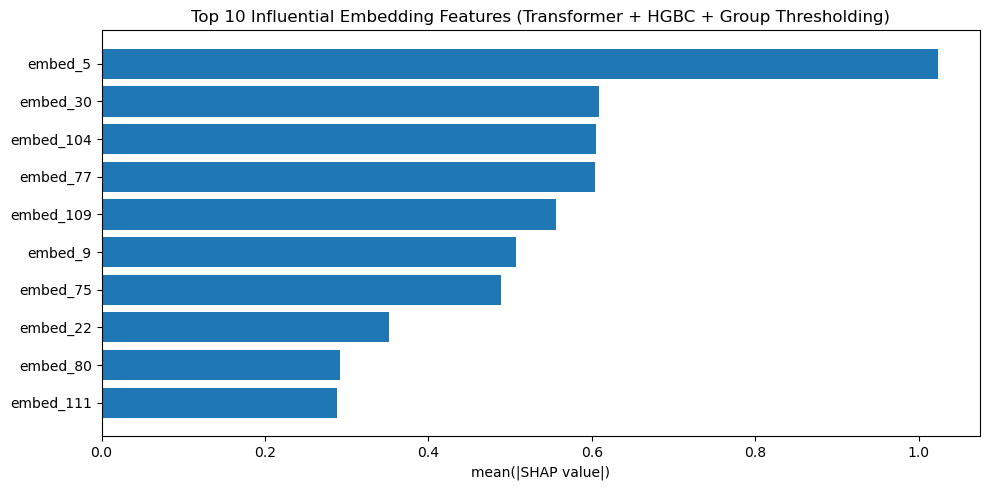


Mean Postprocessed Accuracy Across Folds: 0.8252


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt

# --------------------
# 1. Load and Prepare Data
# --------------------
df = pd.read_csv("scaled_balanced_data.csv")

# Encode age group if categorical
if df['age_group'].dtype == object:
    df['age_group_encoded'] = LabelEncoder().fit_transform(df['age_group'])
else:
    df['age_group_encoded'] = df['age_group']

feature_cols = [c for c in df.columns if c.startswith(('eeg_', 'eye_', 'beh_'))]
X = df[feature_cols].values
y = df['label'].astype(int).values

# Joint sensitive attribute (gender + age)
s_joint = df[['gender', 'age_group_encoded']].astype(str).agg('_'.join, axis=1).values

# --------------------
# 2. Transformer Encoder Model
# --------------------
class FairTransformerEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.eeg_net = nn.Linear(3, 32)
        self.eye_net = nn.Linear(6, 32)
        self.beh_net = nn.Linear(2, 32)
        self.combined_project = nn.Linear(96, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.cls_head = nn.Linear(128, 2)

    def forward(self, eeg, eye, beh):
        eeg_feat = F.relu(self.eeg_net(eeg))
        eye_feat = F.relu(self.eye_net(eye))
        beh_feat = F.relu(self.beh_net(beh))
        combined = torch.cat([eeg_feat, eye_feat, beh_feat], dim=-1)
        combined = self.combined_project(combined).unsqueeze(1)
        trans_out = self.transformer(combined).squeeze(1)
        return self.cls_head(trans_out), trans_out  # return logits and embeddings

device = torch.device("cpu")

# --------------------
# 3. Feature Extraction Function
# --------------------
def extract_features(X, model):
    model.eval()
    eeg = torch.tensor(X[:, :3], dtype=torch.float32).to(device)
    eye = torch.tensor(X[:, 3:9], dtype=torch.float32).to(device)
    beh = torch.tensor(X[:, 9:11], dtype=torch.float32).to(device)
    with torch.no_grad():
        _, emb = model(eeg, eye, beh)
    return emb.cpu().numpy()

# --------------------
# 4. Cross-Validation
# --------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
fold = 0

for train_idx, val_idx in cv.split(X, y):
    fold += 1
    print(f"\n=== Fold {fold} ===")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    s_train, s_val = s_joint[train_idx], s_joint[val_idx]

    # Init and pretrain transformer (with early stopping)
    model = FairTransformerEmbedder().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    patience, best_acc, wait = 5, 0, 0
    best_model_state = None

    for epoch in range(20):  # keep it short; embeddings, not full training
        model.train()
        eeg = torch.tensor(X_train[:, :3], dtype=torch.float32).to(device)
        eye = torch.tensor(X_train[:, 3:9], dtype=torch.float32).to(device)
        beh = torch.tensor(X_train[:, 9:11], dtype=torch.float32).to(device)
        labels = torch.tensor(y_train, dtype=torch.long).to(device)

        preds, _ = model(eeg, eye, beh)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation check
        model.eval()
        eeg_v = torch.tensor(X_val[:, :3], dtype=torch.float32).to(device)
        eye_v = torch.tensor(X_val[:, 3:9], dtype=torch.float32).to(device)
        beh_v = torch.tensor(X_val[:, 9:11], dtype=torch.float32).to(device)
        labels_v = torch.tensor(y_val, dtype=torch.long).to(device)
        with torch.no_grad():
            preds_v, _ = model(eeg_v, eye_v, beh_v)
            acc = (torch.argmax(preds_v, dim=1) == labels_v).float().mean().item()

        print(f"Epoch {epoch+1}, Val Accuracy: {acc:.4f}")
        if acc > best_acc:
            best_acc, wait = acc, 0
            best_model_state = model.state_dict()
        else:
            wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_state)

    # Extract features for HGBC
    X_train_embed = extract_features(X_train, model)
    X_val_embed = extract_features(X_val, model)

    # Train HGBC
    clf = HistGradientBoostingClassifier(random_state=42)
    clf.fit(X_train_embed, y_train)
    probs = clf.predict_proba(X_val_embed)[:, 1]

    # Group Thresholding Post-Processing
    y_post = np.zeros_like(y_val)
    for group in np.unique(s_val):
        idx = (s_val == group)
        if np.sum(idx) == 0:
            continue
        if len(np.unique(y_val[idx])) > 1:
            thresh = np.median(probs[idx])
        else:
            thresh = 0.5
        y_post[idx] = (probs[idx] >= thresh).astype(int)

    # Fairness Metrics
    mf = MetricFrame(
        metrics={"accuracy": accuracy_score,
                 "selection_rate": selection_rate,
                 "tpr": true_positive_rate,
                 "fpr": false_positive_rate},
        y_true=y_val,
        y_pred=y_post,
        sensitive_features=s_val
    )

    results.append({"fold": fold, "accuracy": accuracy_score(y_val, y_post), "mf": mf})

    print(f"Fold {fold} Postprocessed Accuracy: {accuracy_score(y_val, y_post):.4f}")
    print(mf.by_group)

# --------------------
# 5. SHAP Analysis on Last Fold
# --------------------
explainer = shap.Explainer(clf, X_train_embed)
shap_values = explainer(X_val_embed)
shap_df = pd.DataFrame(np.abs(shap_values.values).mean(axis=0), columns=["mean_abs_shap"])
shap_df["feature"] = [f"embed_{i}" for i in range(X_val_embed.shape[1])]
shap_df = shap_df.sort_values("mean_abs_shap", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(shap_df["feature"], shap_df["mean_abs_shap"])
plt.gca().invert_yaxis()
plt.title("Top 10 Influential Embedding Features (Transformer + HGBC + Group Thresholding)")
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.show()

# --------------------
# 6. Report Mean Accuracy Across Folds
# --------------------
mean_acc = np.mean([r["accuracy"] for r in results])
print(f"\nMean Postprocessed Accuracy Across Folds: {mean_acc:.4f}")


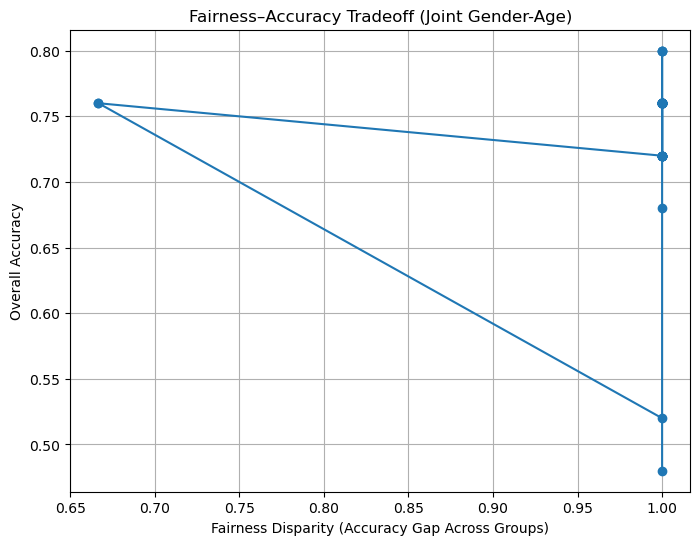

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# --------------------
# Fairness–Accuracy Tradeoff Plot Across Thresholds
# --------------------
def plot_fairness_accuracy_tradeoff(probs, y_true, sensitive_features, group_name="Joint Gender-Age"):
    thresholds = np.linspace(0.0, 1.0, 50)
    accs, disparities = [], []

    for t in thresholds:
        y_pred = (probs >= t).astype(int)
        mf = MetricFrame(
            metrics={"accuracy": accuracy_score,
                     "selection_rate": selection_rate,
                     "tpr": true_positive_rate,
                     "fpr": false_positive_rate},
            y_true=y_true,
            y_pred=y_pred,
            sensitive_features=sensitive_features
        )
        accs.append(accuracy_score(y_true, y_pred))

        # Disparity = max - min accuracy across groups
        group_accs = mf.by_group["accuracy"].values
        disparities.append(np.max(group_accs) - np.min(group_accs))

    plt.figure(figsize=(8, 6))
    plt.plot(disparities, accs, marker="o")
    plt.xlabel("Fairness Disparity (Accuracy Gap Across Groups)")
    plt.ylabel("Overall Accuracy")
    plt.title(f"Fairness–Accuracy Tradeoff ({group_name})")
    plt.grid(True)
    plt.show()

# Example: Run on last fold
plot_fairness_accuracy_tradeoff(probs, y_val, s_val, group_name="Joint Gender-Age")



=== Running Ablation for Full ===

=== Running Ablation for EEG-only ===

=== Running Ablation for Eye-only ===

=== Running Ablation for Behavior-only ===


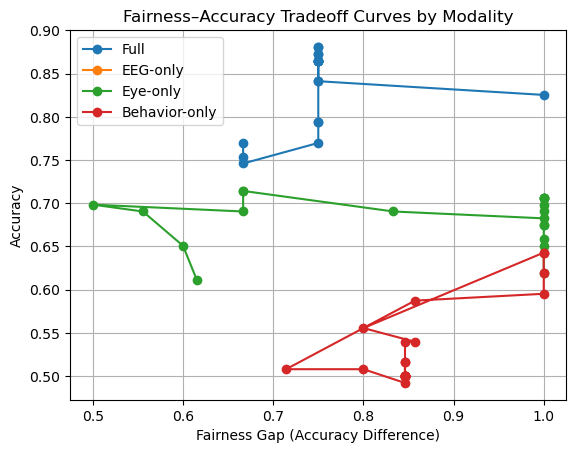

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

# ----------------------
# 1. Load Data
# ----------------------
df = pd.read_csv("scaled_balanced_data.csv")
feature_cols = [c for c in df.columns if c.startswith(("eeg_", "eye_", "beh_"))]
X = df[feature_cols].values
y = df["label"].astype(int).values
sensitive = (df["gender"].astype(str) + "_" + df["age_group"].astype(str)).values  # Joint fairness attr

# ----------------------
# 2. Transformer Embedder
# ----------------------
class FairTransformerEmbedder(nn.Module):
    def __init__(self, eeg_dim, eye_dim, beh_dim):
        super().__init__()
        self.eeg_net = nn.Linear(eeg_dim, 32)
        self.eye_net = nn.Linear(eye_dim, 32)
        self.beh_net = nn.Linear(beh_dim, 32)
        self.combined_project = nn.Linear(96, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

    def forward(self, eeg, eye, beh):
        eeg_feat = F.relu(self.eeg_net(eeg))
        eye_feat = F.relu(self.eye_net(eye))
        beh_feat = F.relu(self.beh_net(beh))
        combined = torch.cat([eeg_feat, eye_feat, beh_feat], dim=-1)
        combined = self.combined_project(combined).unsqueeze(1)
        return self.transformer(combined).squeeze(1)

device = torch.device("cpu")
model = FairTransformerEmbedder(3, 6, 2).to(device)
model.eval()

def extract_features(X):
    eeg = torch.tensor(X[:, :3], dtype=torch.float32).to(device)
    eye = torch.tensor(X[:, 3:9], dtype=torch.float32).to(device)
    beh = torch.tensor(X[:, 9:11], dtype=torch.float32).to(device)
    with torch.no_grad():
        return model(eeg, eye, beh).cpu().numpy()

# ----------------------
# 3. CV + Ablation
# ----------------------
modalities = {
    "Full": slice(None),
    "EEG-only": slice(0, 3),
    "Eye-only": slice(3, 9),
    "Behavior-only": slice(9, 11),
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tradeoff_results = {}

for modality_name, cols in modalities.items():
    print(f"\n=== Running Ablation for {modality_name} ===")

    cv_probs, cv_y_true, cv_sensitive = [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X[train_idx, cols], X[val_idx, cols]
        y_train, y_val_fold = y[train_idx], y[val_idx]
        s_train_fold, s_val_fold = sensitive[train_idx], sensitive[val_idx]

        # Feature extraction: if Full, use Transformer embeddings
        if modality_name == "Full":
            X_train_embed = extract_features(X[train_idx])
            X_val_embed = extract_features(X[val_idx])
        else:
            X_train_embed, X_val_embed = X_train, X_val

        clf = HistGradientBoostingClassifier(random_state=42)
        clf.fit(X_train_embed, y_train)
        fold_probs = clf.predict_proba(X_val_embed)[:, 1]

        cv_probs.extend(fold_probs)
        cv_y_true.extend(y_val_fold)
        cv_sensitive.extend(s_val_fold)

    # Convert
    cv_probs, cv_y_true, cv_sensitive = np.array(cv_probs), np.array(cv_y_true), np.array(cv_sensitive)

    # Tradeoff function
    thresholds = np.linspace(0.1, 0.9, 20)
    results = []
    for t in thresholds:
        y_pred = (cv_probs >= t).astype(int)
        mf = MetricFrame(metrics={"accuracy": accuracy_score},
                         y_true=cv_y_true,
                         y_pred=y_pred,
                         sensitive_features=cv_sensitive)
        acc = accuracy_score(cv_y_true, y_pred)
        fairness_gap = mf.by_group["accuracy"].max() - mf.by_group["accuracy"].min()
        results.append({"threshold": t, "accuracy": acc, "fairness_gap": fairness_gap})

    results_df = pd.DataFrame(results)
    tradeoff_results[modality_name] = results_df

    # Plot tradeoff curve
    plt.plot(results_df["fairness_gap"], results_df["accuracy"], marker="o", label=modality_name)

# ----------------------
# 4. Plot Comparison
# ----------------------
plt.xlabel("Fairness Gap (Accuracy Difference)")
plt.ylabel("Accuracy")
plt.title("Fairness–Accuracy Tradeoff Curves by Modality")
plt.legend()
plt.grid(True)
plt.show()


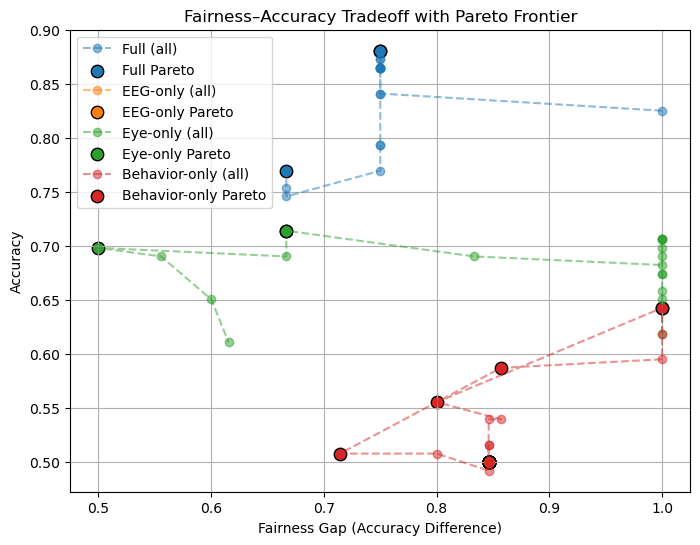

In [ ]:
# ----------------------
# Pareto-Optimal Highlighting
# ----------------------
from scipy.spatial import ConvexHull

plt.figure(figsize=(8,6))

for modality_name, results_df in tradeoff_results.items():
    x = results_df["fairness_gap"].values
    y = results_df["accuracy"].values

    # Find Pareto-optimal points (maximize accuracy, minimize fairness gap)
    pareto_mask = np.ones(x.shape[0], dtype=bool)
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if (y[j] >= y[i] and x[j] <= x[i]) and (y[j] > y[i] or x[j] < x[i]):
                pareto_mask[i] = False
                break

    plt.plot(x, y, marker="o", linestyle="--", alpha=0.5, label=f"{modality_name} (all)")
    plt.scatter(x[pareto_mask], y[pareto_mask], marker="o", s=80, label=f"{modality_name} Pareto", edgecolor="black")

plt.xlabel("Fairness Gap (Accuracy Difference)")
plt.ylabel("Accuracy")
plt.title("Fairness–Accuracy Tradeoff with Pareto Frontier")
plt.legend()
plt.grid(True)
plt.show()
